In [1]:
import os 

from AEMG.data_utils import TrajectoryDataset
from AEMG.systems.utils import get_system

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from AEMG.models import *

from tqdm.notebook import tqdm

In [2]:
system = get_system("pendulum")
config_fname = "config/pendulum_lqr_1K.txt"

with open(config_fname, 'r') as f:
    config = eval(f.read())

traj_dataset = TrajectoryDataset(config)

100%|██████████| 1024/1024 [00:01<00:00, 776.91it/s]


In [3]:
# Get the limits
X_min = np.loadtxt(os.path.join(config['model_dir'], 'X_min.txt'), delimiter=',')
X_max = np.loadtxt(os.path.join(config['model_dir'], 'X_max.txt'), delimiter=',')
print("X_min: ", X_min)
print("X_max: ", X_max)

X_min:  [-0.49999999 -0.5        -3.14159265 -3.13756044]
X_max:  [0.49999999 0.49998885 3.14159265 3.13756044]


## Qualitative Evaluation

Since we know that the system is 2D (and we have implemented the transformation), we can plot the collected trajectories in 2D.

In [4]:
max_plotting = 1000
max_plotting_prob = max_plotting / len(traj_dataset)

  0%|          | 0/1024 [00:00<?, ?it/s]

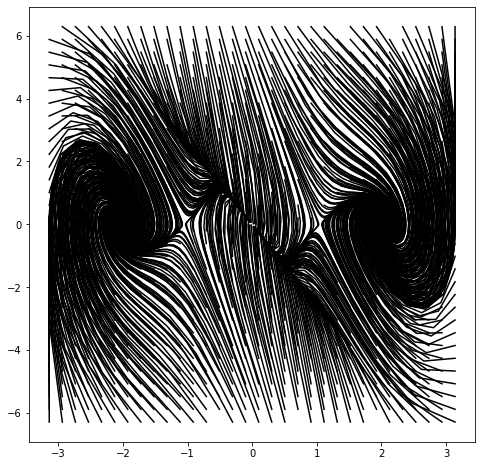

In [5]:
plt.figure(figsize=(8,8))
for i in tqdm(range(len(traj_dataset))):
    if np.random.rand() > max_plotting_prob: continue
    tf_traj = []
    for j in range(len(traj_dataset[i])):
        tf_traj.append(system.inverse_transform(traj_dataset[i][j]))
    tf_traj = np.array(tf_traj)
    plt.plot(tf_traj[:,0], tf_traj[:,1], color='black')
plt.show()

In [6]:
encoder  = Encoder(config['high_dims'], config['low_dims'])
decoder  = Decoder(config['low_dims'], config['high_dims'])
dynamics = LatentDynamics(config['low_dims'])

encoder = torch.load(os.path.join(config['model_dir'], 'encoder.pt'))
decoder = torch.load(os.path.join(config['model_dir'], 'decoder.pt'))
dynamics = torch.load(os.path.join(config['model_dir'], 'dynamics.pt'))

  0%|          | 0/21 [00:00<?, ?it/s]

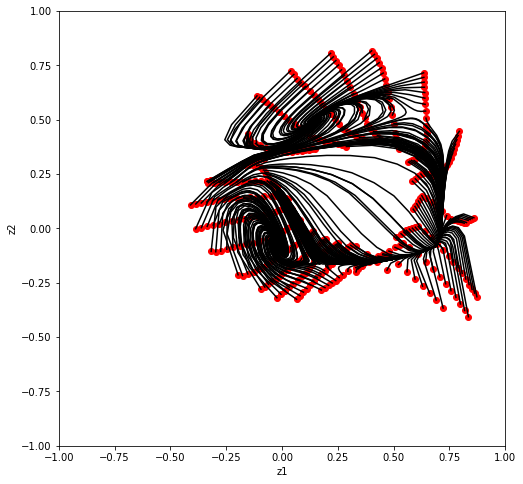

In [10]:
true_bounds = system.get_true_bounds()
resolution = 21
traj_len = len(traj_dataset[0])

ts = np.linspace(true_bounds[0,0], true_bounds[0,1], resolution)
tdots = np.linspace(true_bounds[1,0], true_bounds[1,1], resolution)

plt.figure(figsize=(8,8))
plt.xlim(-1., 1.)
plt.ylim(-1., 1.)
plt.xlabel("z1")
plt.ylabel("z2")
for i in tqdm(range(resolution)):
    for j in range(resolution):
        x0 = np.array([ts[i], tdots[j]])
        x0 = system.transform(x0)
        x0 = (x0 - X_min) / (X_max - X_min)
        x0 = torch.tensor(x0, dtype=torch.float32)
        z0 = encoder(x0)
        z_traj = [z0]
        for k in range(traj_len):
            z_traj.append(dynamics(z_traj[-1]))
        z_traj = torch.stack(z_traj)
        z_traj = z_traj.detach().numpy()
        plt.plot(z_traj[:,0], z_traj[:,1], color='black')
        plt.scatter(z_traj[0,0], z_traj[0,1], color='red')

  0%|          | 0/21 [00:00<?, ?it/s]

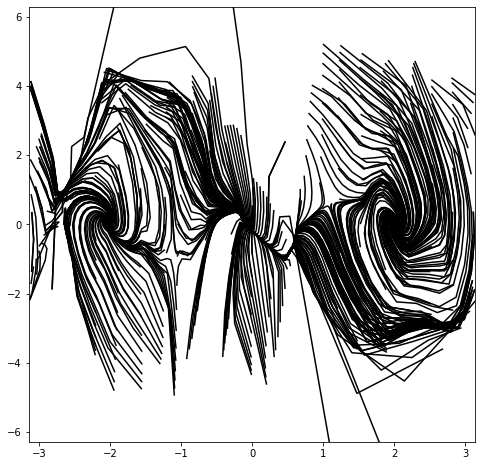

In [8]:
true_bounds = system.get_true_bounds()
resolution = 21
traj_len = len(traj_dataset[0])

ts = np.linspace(true_bounds[0,0], true_bounds[0,1], resolution)
tdots = np.linspace(true_bounds[1,0], true_bounds[1,1], resolution)

plt.figure(figsize=(8,8))
plt.xlim(-np.pi, np.pi)
plt.ylim(-2*np.pi, 2*np.pi)
for i in tqdm(range(resolution)):
    for j in range(resolution):
        x0 = np.array([ts[i], tdots[j]])
        x0 = system.transform(x0)
        x0 = (x0 - X_min) / (X_max - X_min)
        x0 = torch.tensor(x0, dtype=torch.float32)
        z0 = encoder(x0)
        z_traj = [z0]
        for k in range(traj_len):
            z_traj.append(dynamics(z_traj[-1]))

        x_traj = []
        for k in range(traj_len):
            x_traj.append(decoder(z_traj[k]))
        x_traj = torch.stack(x_traj)
        x_traj = x_traj.detach().numpy()
        x_traj = x_traj * (X_max - X_min) + X_min
        x_traj = np.array([system.inverse_transform(x_traj[k]) for k in range(traj_len)])
        # Break up the trajectory into segments if the angle wraps around
        # Plot each segment ignoring the wrap around
        start = 0
        for k in range(1, traj_len):
            if abs(x_traj[k,0] - x_traj[k-1,0]) > np.pi:
                plt.plot(x_traj[start:k,0], x_traj[start:k,1], color='black')
                start = k
        plt.plot(x_traj[start:,0], x_traj[start:,1], color='black')

## Quantitative Evaluation

  0%|          | 0/21 [00:00<?, ?it/s]

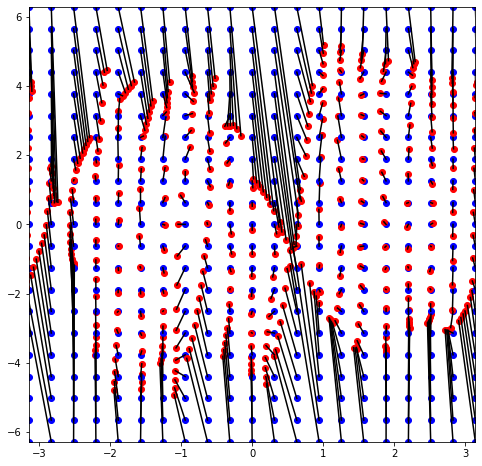

In [9]:
# Reconstruct all points in the ts and tdots grid
# Plot the reconstructed points with a line connecting them

plt.figure(figsize=(8,8))
plt.xlim(-np.pi, np.pi)
plt.ylim(-2*np.pi, 2*np.pi)

for i in tqdm(range(resolution)):
    for j in range(resolution):
        x_orig = np.array([ts[i], tdots[j]])
        x = system.transform(x_orig)
        x = (x - X_min) / (X_max - X_min)
        x = torch.tensor(x, dtype=torch.float32)
        z = encoder(x)
        x_recon = decoder(z)
        x_recon = x_recon.detach().numpy()
        x_recon = x_recon * (X_max - X_min) + X_min
        x_recon = system.inverse_transform(x_recon)
        # If the angle wraps around, plot them close to each other
        if abs(x_recon[0] - x_orig[0]) > np.pi:
            if x_recon[0] > 0:
                x_recon[0] -= 2*np.pi
            else:
                x_recon[0] += 2*np.pi
        plt.scatter(x_orig[0], x_orig[1], color='blue')
        plt.scatter(x_recon[0], x_recon[1], color='red')
        plt.plot([x_orig[0], x_recon[0]], [x_orig[1], x_recon[1]], color='black')